## Config

In [1]:
# config.py

import random
import numpy as np
import torch

In [2]:
class Config:
    def __init__(self):
        # Device configuration
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_cuda else "cpu")

        # Random seed for reproducibility
        self.seed = 42

    def set_seed(self):
        """
        Set the random seed for reproducibility across different libraries.
        """
        random.seed(self.seed)  # Python random module
        np.random.seed(self.seed)  # NumPy
        torch.manual_seed(self.seed)  # PyTorch
        if self.use_cuda:
            torch.cuda.manual_seed(self.seed)  # GPU-specific seed
            torch.cuda.manual_seed_all(self.seed)  # For multi-GPU setups
            torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
            torch.backends.cudnn.benchmark = False  # Disable auto-tuning for deterministic behavior

    def print_config(self):
        """
        Print the configuration for debugging purposes.
        """
        print(f"Using CUDA: {self.use_cuda}")
        print(f"Device: {self.device}")
        print(f"Random Seed: {self.seed}")

In [3]:
# Example usage
if __name__ == "__main__":
    config = Config()
    config.set_seed()
    config.print_config()


Using CUDA: True
Device: cuda
Random Seed: 42


## Cuda test

In [4]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

if cuda_available:
    # Print the name of the GPU
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

    # Check current device
    print(f"Current Device: {torch.cuda.current_device()}")

    # CUDA version (PyTorch-specific)
    print(f"PyTorch CUDA Version: {torch.version.cuda}")
else:
    print("CUDA is not available. Check installation or GPU configuration.")


CUDA Available: True
GPU Name: NVIDIA GeForce GTX 1060
Current Device: 0
PyTorch CUDA Version: 11.8


## Data Loader Pipeline

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# Define transformations (same as before)
common_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the entire dataset
dataset = datasets.ImageFolder(root='../data', transform=common_transforms)

# Split the dataset
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

In [7]:
# Print dataset statistics
print(f"Classes: {dataset.classes}")
print(f"Total samples: {len(dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Total samples: 7153
Training samples: 5722
Validation samples: 1431


### Image Vis

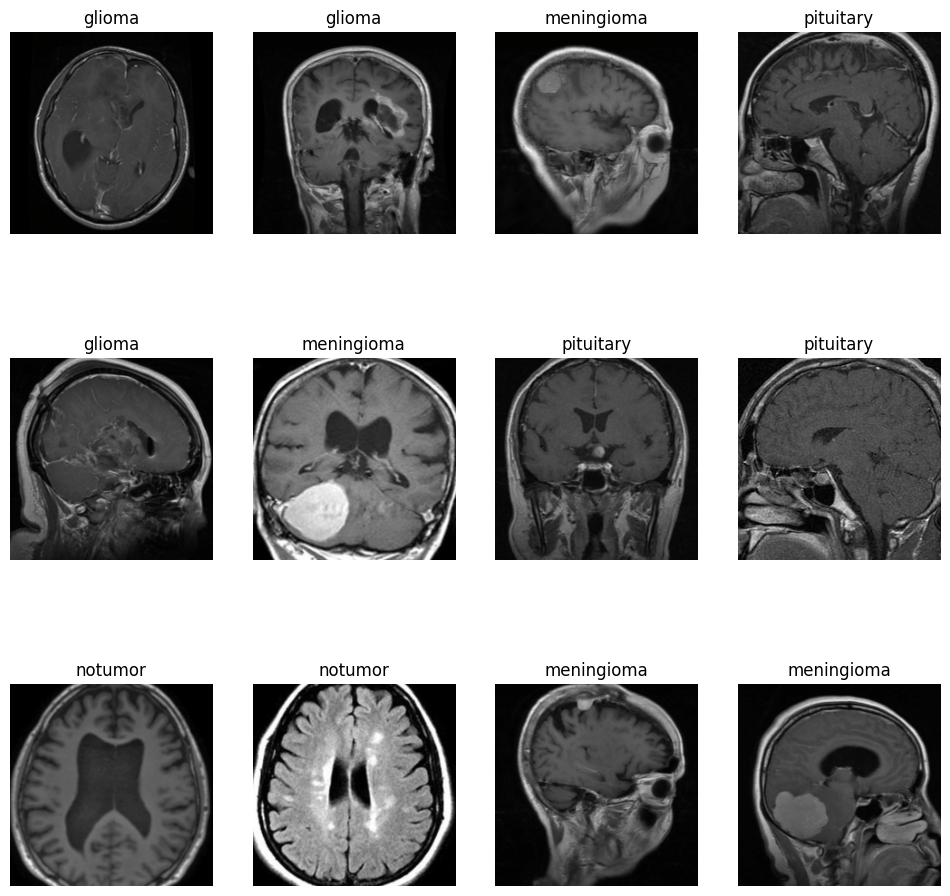

In [8]:
# Helper function to unnormalize and display images
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor format
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Undo normalization
    img = np.clip(img, 0, 1)  # Clip values to [0, 1] range
    plt.imshow(img)
    plt.axis('off')

# Visualize images from the training dataset
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(12, 12))
for idx in range(12):  # Show the first 12 images
    ax = fig.add_subplot(3, 4, idx + 1)
    imshow(images[idx])
    ax.set_title(dataset.classes[labels[idx]])
plt.show()


## Model Pipeline

### Simple CNN

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.25)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 56 * 56, 512)  # Corrected input features
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = F.relu(self.conv1(x))  # [batch, 32, 224, 224]
        x = self.pool(F.relu(self.conv2(x)))  # [batch, 64, 112, 112]
        x = self.pool(F.relu(self.conv3(x)))  # [batch, 128, 56, 56]
        
        # Flatten
        x = x.view(-1, 128 * 56 * 56)  # [batch, 401408]
        
        # Fully connected layers with dropout and ReLU
        x = self.dropout(x)
        x = F.relu(self.fc1(x))  # [batch, 512]
        x = self.fc2(x)          # [batch, num_classes]
        
        return x


### Advance CNN

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class ResidualBlock(nn.Module):
    """
    A simple Residual Block with two convolutional layers.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride !=1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class AdvancedCNN(nn.Module):
    def __init__(self, num_classes):
        super(AdvancedCNN, self).__init__()
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)
        
        # Residual blocks
        self.layer1 = self._make_layer(64, 64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2)
        
        # Global average pooling and fully connected layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Initial layers
        x = F.relu(self.bn1(self.conv1(x)))  # [batch, 64, 112, 112]
        x = self.pool(x)  # [batch, 64, 56, 56]
        
        # Residual layers
        x = self.layer1(x)  # [batch, 64, 56, 56]
        x = self.layer2(x)  # [batch, 128, 28, 28]
        x = self.layer3(x)  # [batch, 256, 14, 14]
        
        # Global average pooling
        x = self.avg_pool(x)  # [batch, 256, 1, 1]
        x = x.view(x.size(0), -1)  # [batch, 256]
        
        # Fully connected layer
        x = self.fc(x)  # [batch, num_classes]
        
        return x


### Training Pipeline

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time
import os

In [14]:
def train_model(model, train_loader, val_loader, config, num_epochs=25, patience=3, checkpoint_dir='checkpoints'):
    """
    Train the given model using the provided data loaders and configuration.
    Incorporates checkpointing and early stopping based on validation accuracy.
    
    Args:
        model (nn.Module): The neural network model to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        config (Config): Configuration object containing device and seed.
        num_epochs (int): Maximum number of training epochs.
        patience (int): Number of epochs to wait for improvement before stopping.
        checkpoint_dir (str): Directory to save model checkpoints.
    
    Returns:
        model (nn.Module): Trained model with best validation accuracy.
        history (dict): Training and validation loss and accuracy history.
    """
    device = config.device
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Initialize TensorBoard
    writer = SummaryWriter(log_dir='logs')
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    # Initialize variables for early stopping and checkpointing
    best_val_acc = 0.0
    epochs_no_improve = 0
    best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
    
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    for epoch in range(num_epochs):
        since = time.time()
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            total_samples = 0
            
            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                # Track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only in train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)
            
            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples
            
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            # TensorBoard logging
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
                writer.add_scalar('Loss/train', epoch_loss, epoch)
                writer.add_scalar('Accuracy/train', epoch_acc, epoch)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                writer.add_scalar('Loss/val', epoch_loss, epoch)
                writer.add_scalar('Accuracy/val', epoch_acc, epoch)
                
                # Check for improvement
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    epochs_no_improve = 0
                    # Save the best model
                    torch.save(model.state_dict(), best_model_path)
                    print(f"Validation accuracy improved. Model saved to {best_model_path}")
                else:
                    epochs_no_improve += 1
                    print(f"No improvement in validation accuracy for {epochs_no_improve} epoch(s)")
        
        time_elapsed = time.time() - since
        print(f"Epoch completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s\n")
        
        # Early stopping
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered. No improvement in validation accuracy for {patience} consecutive epochs.")
            break
    
    writer.close()
    
    # Load the best model before returning
    model.load_state_dict(torch.load(best_model_path))
    print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")
    
    return model, history


In [15]:
def evaluate_model(model, val_loader, config):
    """
    Evaluate the trained model on the validation set.
    
    Args:
        model (nn.Module): The trained model.
        val_loader (DataLoader): DataLoader for validation data.
        config (Config): Configuration object containing device.
    
    Returns:
        val_accuracy (float): Validation accuracy in percentage.
    """
    device = config.device
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    
    val_accuracy = 100 * correct / total
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    return val_accuracy

In [16]:
def save_model(model, path):
    """
    Save the model state dictionary to the specified path.
    Creates the parent directory if it does not exist.

    Args:
        model (nn.Module): The model to save.
        path (str): The file path to save the model.
    """
    directory = os.path.dirname(path)
    if directory and not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
        print(f"Created directory {directory}")
    
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


In [17]:
def load_model(model, path, device):
    """
    Load the trained model state dictionary from a checkpoint.

    Args:
        model (nn.Module): The model to load the state into.
        path (str): The file path to the checkpoint.
        device (torch.device): The device to map the model to.

    Returns:
        model (nn.Module): The model with loaded weights.
    """
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Model loaded from {path}")
    return model

In [18]:
def save_model_full(model, optimizer, epoch, path):
    """
    Save the model and optimizer state dictionaries along with the current epoch.

    Args:
        model (nn.Module): The model to save.
        optimizer (Optimizer): The optimizer.
        epoch (int): Current epoch number.
        path (str): File path to save the checkpoint.
    """
    directory = os.path.dirname(path)
    if directory and not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
        print(f"Created directory {directory}")
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved to {path}")


In [19]:
def load_model_full(model, optimizer, path, device):
    """
    Load the model and optimizer state dictionaries along with the epoch number.

    Args:
        model (nn.Module): The model to load the state into.
        optimizer (Optimizer): The optimizer to load the state into.
        path (str): File path to load the checkpoint from.
        device (torch.device): The device to map the model and optimizer to.

    Returns:
        epoch (int): The epoch number from which training can be resumed.
    """
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print(f"Checkpoint loaded from {path} at epoch {epoch}")
    return epoch


### Model Training

In [20]:
# from config import Config

# Initialize configuration
config = Config()
config.set_seed()
config.print_config()

# Number of classes
num_classes = len(train_dataset.dataset.classes)  # Assuming train_dataset is from ImageFolder
print(num_classes)

# Initialize models
model1 = SimpleCNN(num_classes=num_classes).to(config.device)
model2 = AdvancedCNN(num_classes=num_classes).to(config.device)

# If using multiple GPUs, uncomment the following lines
# if torch.cuda.device_count() > 1:
#     model1 = nn.DataParallel(model1)
#     model2 = nn.DataParallel(model2)


Using CUDA: True
Device: cuda
Random Seed: 42
4


#### Training Simple CNN

In [24]:
# Clear GPU cache
torch.cuda.empty_cache()

In [25]:
# Define number of epochs
num_epochs = 10

print("Training Model 1: Simple Custom CNN")
model1, history1 = train_model(model1, train_loader, val_loader, config, num_epochs=num_epochs)

Training Model 1: Simple Custom CNN
Epoch 1/10
----------
Train Loss: 0.2463 Acc: 0.9091
Val Loss: 0.2161 Acc: 0.9133
Validation accuracy improved. Model saved to checkpoints\best_model.pth
Epoch completed in 7m 32s

Epoch 2/10
----------
Train Loss: 0.1054 Acc: 0.9633
Val Loss: 0.2441 Acc: 0.9189
Validation accuracy improved. Model saved to checkpoints\best_model.pth
Epoch completed in 7m 50s

Epoch 3/10
----------
Train Loss: 0.0585 Acc: 0.9804
Val Loss: 0.2014 Acc: 0.9371
Validation accuracy improved. Model saved to checkpoints\best_model.pth
Epoch completed in 8m 9s

Epoch 4/10
----------
Train Loss: 0.0356 Acc: 0.9914
Val Loss: 0.2398 Acc: 0.9350
No improvement in validation accuracy for 1 epoch(s)
Epoch completed in 7m 49s

Epoch 5/10
----------
Train Loss: 0.0465 Acc: 0.9860
Val Loss: 0.3137 Acc: 0.9350
No improvement in validation accuracy for 2 epoch(s)
Epoch completed in 7m 52s

Epoch 6/10
----------
Train Loss: 0.0507 Acc: 0.9853
Val Loss: 0.3061 Acc: 0.9371
No improvement i

C:\Users\timmy\AppData\Local\Temp\ipykernel_25928\1363358352.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Loaded best model with validation accuracy: 0.9371


In [26]:
# Evaluate the trained model
val_accuracy = evaluate_model(model1, val_loader, config)

Validation Accuracy: 93.71%


In [27]:
val_accuracy

93.71069182389937

In [28]:
# Save the trained model
save_model(model1, 'checkpoints/simple_cnn.pth')

Model saved to checkpoints/simple_cnn.pth


## Inference

In [29]:
from PIL import Image

In [30]:
def load_model(model, path, device):
    """
    Load the trained model state dictionary from a checkpoint.

    Args:
        model (nn.Module): The model to load the state into.
        path (str): The file path to the checkpoint.
        device (torch.device): The device to map the model to.

    Returns:
        model (nn.Module): The model with loaded weights.
    """
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Model loaded from {path}")
    return model

In [31]:
def preprocess_image(image_path):
    """
    Preprocess an image for inference.

    Args:
        image_path (str): Path to the input image.

    Returns:
        tensor (torch.Tensor): Preprocessed image tensor.
    """
    # Define transformations (these should match those used during training)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize image to match model input size
        transforms.ToTensor(),         # Convert to PyTorch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')  # Ensure 3-channel image
    tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image, tensor

In [32]:
def predict_image(model, image_path, class_names, device):
    """
    Perform inference on an input image.

    Args:
        model (nn.Module): The trained model.
        image_path (str): Path to the input image.
        class_names (list): List of class names.
        device (torch.device): The device to use for inference.

    Returns:
        image (PIL.Image): The input image.
        predicted_class (str): Predicted class label.
    """
    # Preprocess the image
    image, tensor = preprocess_image(image_path)
    tensor = tensor.to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(tensor)
        _, predicted_idx = torch.max(outputs, 1)
        predicted_class = class_names[predicted_idx.item()]

    return image, predicted_class


In [33]:
import matplotlib.pyplot as plt

def display_prediction(image, predicted_class):
    """
    Display the input image with the predicted class overlaid.

    Args:
        image (PIL.Image): The input image.
        predicted_class (str): The predicted class label.
    """
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title(f"Predicted Class: {predicted_class}", fontsize=16, color='blue')
    plt.show()


In [34]:
train_dataset.dataset.classes

['glioma', 'meningioma', 'notumor', 'pituitary']

C:\Users\timmy\AppData\Local\Temp\ipykernel_25928\1686156112.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device)

Model loaded from checkpoints/best_model.pth
Predicted Class: glioma


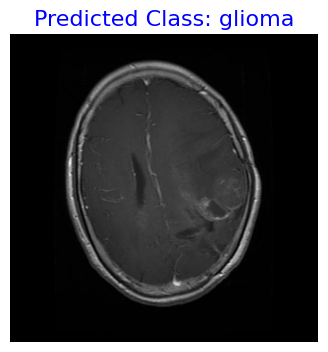

Predicted Class: meningioma


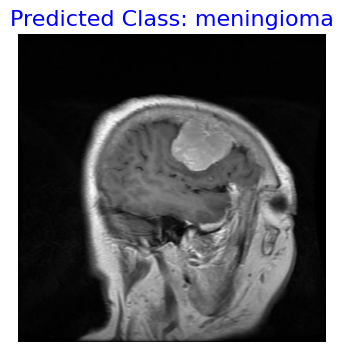

Predicted Class: notumor


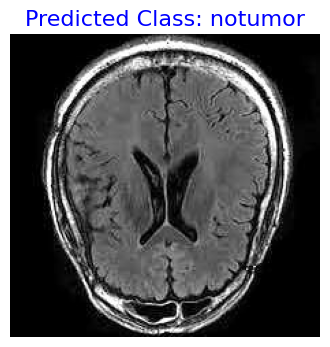

In [36]:
if __name__ == "__main__":
    # Define class names (example for 10 classes)
    class_names = train_dataset.dataset.classes

    # Initialize the model
    model = SimpleCNN(num_classes=len(class_names))

    # Load the trained model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = load_model(model, 'checkpoints/best_model.pth', device)

    # Perform inference on an image
    image_path = ['../data/glioma/gl-0002.jpg', "../data/meningioma/me-0002.jpg", "../data/notumor/no-0002.jpg"]
    for path in image_path:
        input_image, predicted_class = predict_image(model, path, class_names, device)

        # Display results using matplotlib
        print(f"Predicted Class: {predicted_class}")
        display_prediction(input_image, predicted_class)